# Assignment 5: EE708
## Dhruv Gupta, 240354

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore',category='FutureWarning')
plt.style.use("ggplot")

from sklearn.datasets import load_iris #to load iris dataset
from sklearn.model_selection import train_test_split # to split training and testing sets with a random seed

## Problem 7
Perceptron Learning Algorithm for Binary Classification: For the dataset in A5-P1.csv, implement a Perceptron using gradient descent to classify the data points.
- Activation function: step
- Weight initialization: random (using numpy package)
- Learning rate: 0.01
- Number of weight update iterations: 20

Visualize the decision boundary by plotting the dataset points and the separating line. (Mark data points for different classes with different colors.)
Rerun the code with different random weight initializing to understand the importance of initialization.

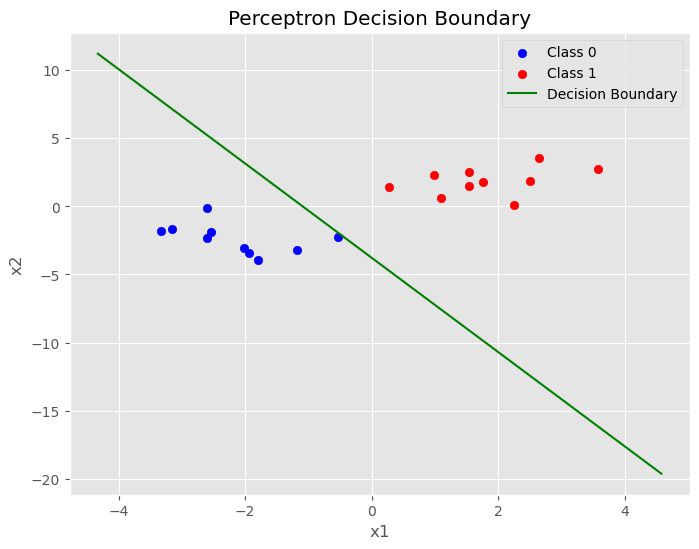

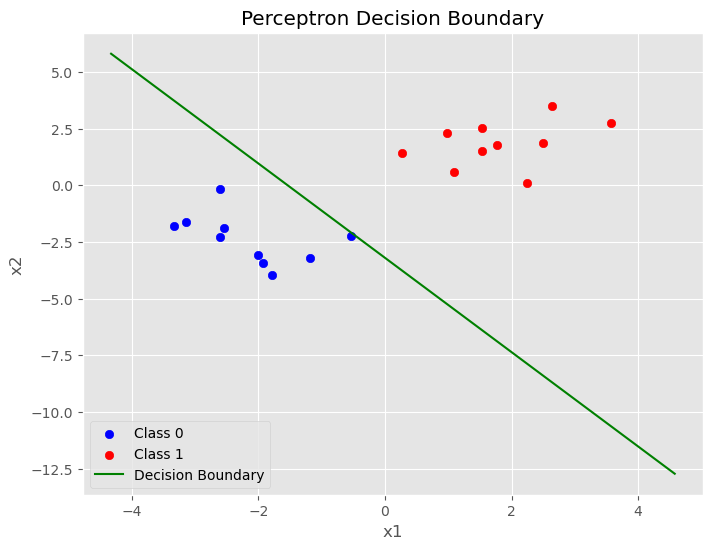

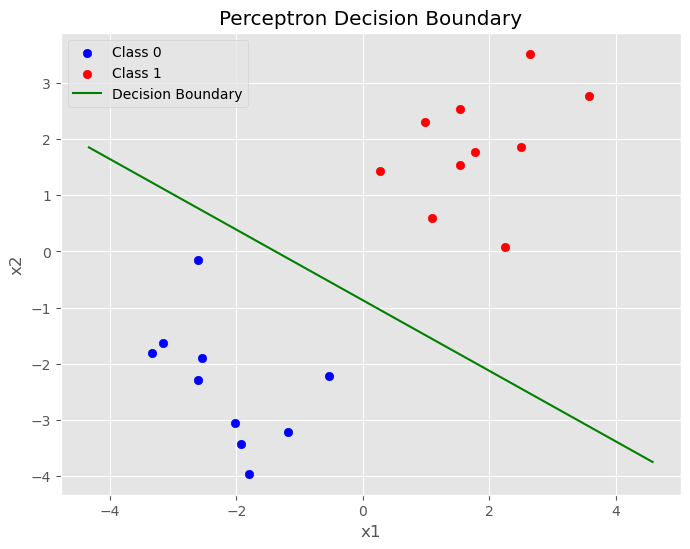

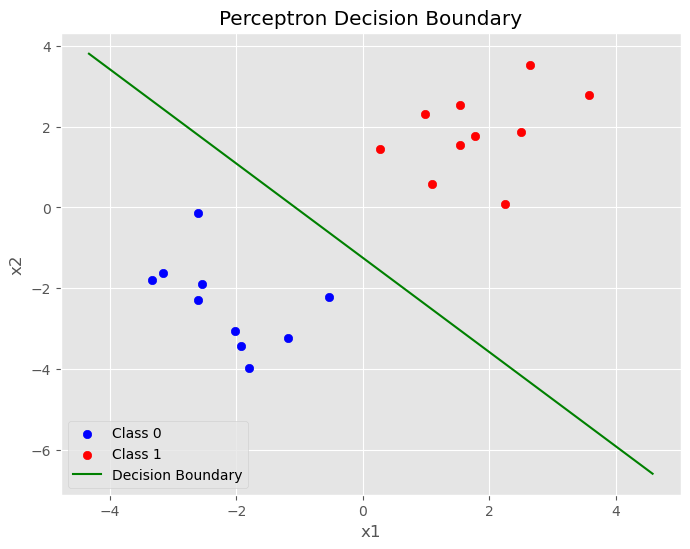

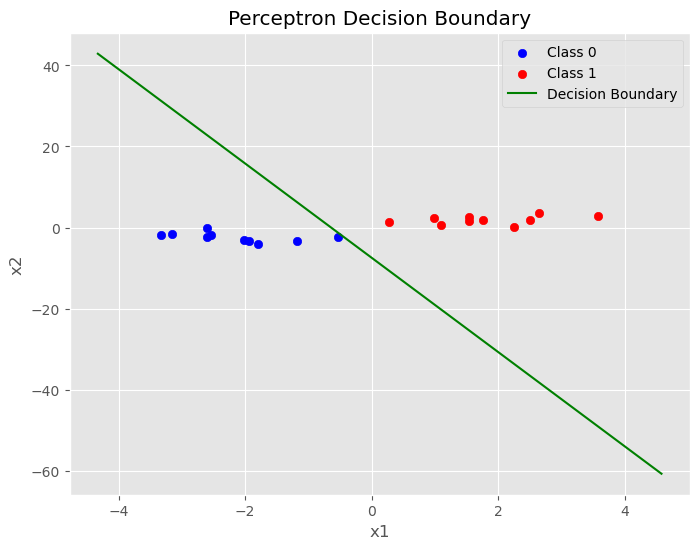

In [161]:
data = pd.read_csv('A5_P1.csv')
X = data[['X1', 'X2']].values
y = data['y'].values

# weight initialization
def initialize_weights(input_dim):
    weights = np.random.rand(input_dim + 1)  # +1 for bias term
    return weights

# activation function
def step_activation(z):
    return np.where(z >= 0, 1, 0)  #returns 1 for positive, 0 for neg

# perceptron wegight update
def perceptron_learning(X, y, weights, learning_rate, num_iterations):
    for _ in range(1,num_iterations+1):
        for i in range(len(X)):
            x_i = np.append(1, X[i])  # Add bias term
            prediction = step_activation(np.dot(x_i, weights))
            weights -= learning_rate * (prediction - y[i]) * x_i
    return weights

# decision boundary
def plotboundary(X, y, weights):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[y == 0, 0], X[y == 0, 1], color='blue', label='Class 0')
    plt.scatter(X[y == 1, 0], X[y == 1, 1], color='red', label='Class 1')
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    x_values = np.linspace(x_min, x_max, 100)
    y_values = (-weights[0] - weights[1]*x_values) / weights[2]
    plt.plot(x_values, y_values, color='green', label='Decision Boundary')
    
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Perceptron Decision Boundary')
    plt.legend()
    plt.show()

# function to run everything
def perceptron():
    data = pd.read_csv('A5_P1.csv')
    X = data[['X1', 'X2']].values
    y = data['y'].values
    
    input_dim = X.shape[1]
    weights = initialize_weights(input_dim)
    
    learning_rate = 0.01
    num_iterations = 20
    
    weights = perceptron_learning(X, y, weights, learning_rate, num_iterations)
    
    plotboundary(X, y, weights)

if __name__ == "__main__":
    
    for _ in range(5):
        perceptron()


## Problem 8
**Neural Network from Scratch**\
Using the Iris dataset, implement a feedforward neural network with one hidden layer (with five neurons) and train it using Stochastic Gradient Descent (SGD) to classify the species correctly.
- Load the Iris dataset from sklearn.datasets.load_iris().
- Split the dataset into training (80%) and testing (20%) subsets.
- Standardize the features to have zero mean and unit variance.
- Activation functions: tanh for the hidden layer and softmax for the output layer.
- Loss function: Mean Squared Error (MSE)
- Weight initialization: random
- Learning rate: 0.01
- Number of weight update iterations: 1000

Implement forward and backward propagation.
- Plot the training and testing loss vs. epochs.
- Plot the training and testing accuracy over epochs

## Answer: (sequence of steps)
loading the dataset, train test split and scaling of features\
(note: scaled the test set according to the mean and std of the train set, this prevents any information leakage)
$$X_{standardised} = \frac{X-\mu}{\sigma} $$

In [162]:
#loading the dataset
df = load_iris()
X = df.data; y = df.target

#performing train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

#standardizing the data such that it has zero mean and unit variance
mean = np.mean(X_train, axis=0)
dev = np.std(X_train, axis=0)
X_train = (X_train-mean)/dev
X_test = (X_test - mean)/dev

# one hot encoding the y data and converting it to (120,3) shape for future use
y_train = np.eye(3)[y_train]
y_test = np.eye(3)[y_test]

activation functions: tanh for hidden layer and softmax for output layer.\
tanh is implemented because this is a classification task.
$$ tanh(Z) = \frac{e^Z - e^{-Z}}{e^Z+e^{-Z}}$$
softmax is implemented as:
$$ \text{softmax}(Z_i) = \frac{e^{Z_i}}{\sum_{j=1}^{n}e^{Z_j}} = \frac{e^{Z_i-max(Z)}}{\sum_{j=1}^{n}e^{Z_j-max(Z)}}$$ 

In [163]:
#activation functions
def tanh(Z):
    return np.tanh(Z)
def diff_tanh(Z):
    return 1 - (tanh(Z)**2)

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return expZ / np.sum(expZ, axis=1, keepdims=True)

#one hot encoding function
def one_hot_encode(arr):
    arr = np.array(arr)
    maxidx = np.argmax(arr)
    maxelement = np.max(arr)
    encoded = np.zeros(arr.shape, dtype=int)
    encoded[maxidx] = 1
    return encoded

rough sketech of model architecture overall:

Loss function (MSE) and derivative of loss function:

In [164]:
def mse_loss(y_ground, y_pred):
    return np.mean(((y_ground - y_pred)**2)/2)

def diff_mse_loss(y_ground, y_pred):
    return y_ground - y_pred

Weight initialisation

In [168]:
np.random.seed(38)
input_dimensions = 4 #120,4 matrix for input
hidden_dimensions = 5 #120,5 matrix for hidden layer
output_dimensions = 3 #120,3 one hot encoded for output layer
learning_rate = 0.01

W1 = np.random.randn(input_dimensions, hidden_dimensions) #W1 matrix of (4,5)
b1 = np.zeros((1,hidden_dimensions)) # b1 matrix of (1,5); will be broadcast into (120,5) later
W2 = np.random.rand(hidden_dimensions, output_dimensions) #W2 matrix of (4,3)
b2 = np.zeros((1,output_dimensions)) #b2 matrix of (1,3); will be broadcast into (120,3) later

training:

In [169]:
epochs = 1000
train_loss = []; test_loss = []
train_accuracy = []; test_accuracy = []

for epoch in range(epochs):
    # forward pass step
    Z1 = X_train @ W1 + b1
    A1 = tanh(Z1)
    Z2 = A1 @ W2 + b2
    y_pred = softmax(Z2)
    
    #losses and accuracies
    loss = mse_loss(y_pred=y_pred,y_ground = y_train)
    accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_train, axis=1))
    train_accuracy.append(accuracy)
    train_loss.append(loss)
    
    # backward pass: using formulas covered in lecture slides
    
    dZ2 = diff_mse_loss(y_pred=y_pred, y_ground = y_train)
    dW2 = A1.T @ dZ2 / len(X_train)
    db2 = np.mean(dZ2, axis=0, keepdims=True)
    
    dA1 = dZ2 @ W2.T
    dZ1 = dA1 * diff_tanh(Z1)
    dW1 = X_train.T @ dZ1 / len(X_train)
    db1 = np.mean(dZ1, axis=0, keepdims=True)
    
    # weight update
    W1 = W1 + learning_rate*dW1
    b1 = b1 + learning_rate*db1
    W2 = W2 + learning_rate*dW2
    b2 = b2 + learning_rate*db2
    
    # testing performance
    A1_test = tanh(X_test @ W1 + b1)
    y_test_pred = softmax(A1_test @ W2 + b2)
    tloss = mse_loss(y_test, y_test_pred)
    tacc = np.mean(np.argmax(y_test_pred, axis=1) == np.argmax(y_test, axis=1))
    test_loss.append(tloss)
    test_accuracy.append(tacc)

print(f"Maximum accuracy over test set is: {round(max(test_accuracy)*100, 2)}%")
print(f"Maximum accuracy over train set is: {round(max(train_accuracy)*100, 2)}%")

Maximum accuracy over test set is: 96.67%
Maximum accuracy over train set is: 91.67%


plotting the outputs:

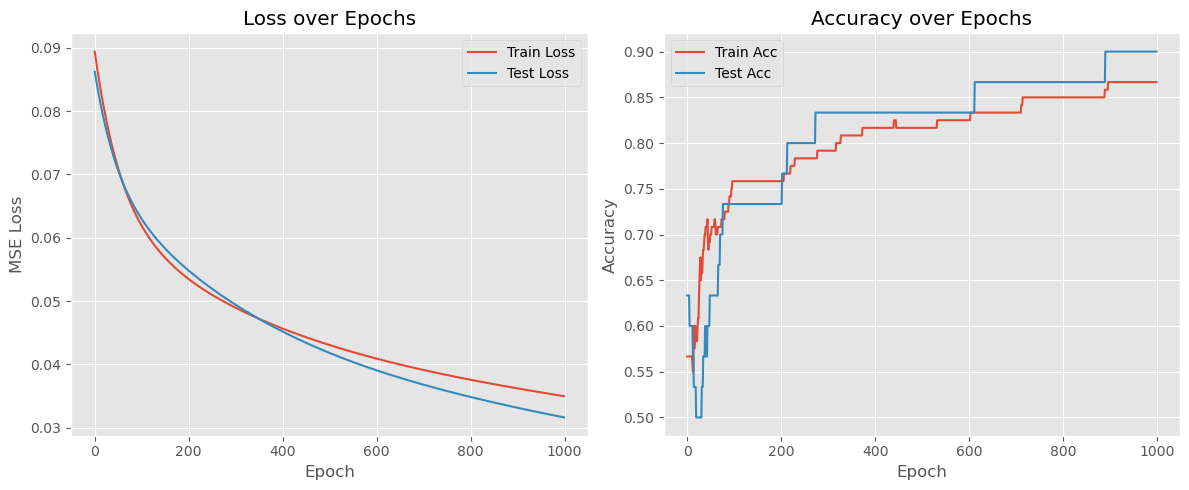

In [167]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Acc')
plt.plot(test_accuracy, label='Test Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()